# Merge sensor data with MET lables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np


os.chdir("/home/cernerrood246/University/DataMining")
pd.set_option("display.precision", 2)

In [2]:
participants_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']

## Load Datasets

### Load MET

In [3]:
MET_all_list = [pd.read_pickle(f"preprocessed_dataset/{participant}/MET.pkl") for participant in participants_list]
MET_all_list[1]


,Time[s],Delta_Time,MET,Activity
Time,,,,
2021-11-25 17:17:43,1.0,0 days 00:00:00,0.72,1.0
2021-11-25 17:17:44,2.0,0 days 00:00:01,0.72,1.0
2021-11-25 17:17:45,3.0,0 days 00:00:02,0.72,1.0
2021-11-25 17:17:46,4.0,0 days 00:00:03,0.72,1.0
2021-11-25 17:17:47,5.0,0 days 00:00:04,0.71,1.0
...,...,...,...,...
2021-11-25 17:56:28,2326.0,0 days 00:38:45,0.00,5.0
2021-11-25 17:56:29,2327.0,0 days 00:38:46,0.00,5.0
2021-11-25 17:56:30,2328.0,0 days 00:38:47,0.00,5.0


### Load Demographics


In [4]:
demographics_df = pd.read_csv("original_dataset/Demographics.csv")
#dummy encoding Gender
demographics_df = pd.get_dummies(demographics_df, columns = ["Gender"], dtype=int)
demographics_df = demographics_df.drop(columns=["Participant", "Comments"])
demographics_df.to_pickle("preprocessed_dataset/demographics.pkl")

### Load Fitbit

In [5]:
fitbit_path = "Fitbit_data/average_data_5S_new/average_data_5S_new"
fitbit_df_list = []
for df in os.listdir(fitbit_path):
    temp_df = pd.read_csv(f"{fitbit_path}/{df}")
    #convert index to datetime
    temp_df = temp_df.rename(columns={"Unnamed: 0": "Time"})
    temp_df["Time"] = pd.to_datetime(temp_df["Time"])

    temp_df = temp_df.set_index("Time")
    #upsample to 1 second without filling
    temp_df = temp_df.resample("1S").asfreq().copy()

    #fill next 4 values with the previous value
    temp_df = temp_df.ffill(limit=4)
    temp_df = temp_df[temp_df['value__bpm'].notna()]

    
    fitbit_df_list.append(temp_df)
    
fitbit_df_all = pd.concat(fitbit_df_list, axis=0)
fitbit_df_all 


,value__bpm,value__confidence
Time,,
2021-11-20 09:11:40,104.0,0.0
2021-11-20 09:11:41,104.0,0.0
2021-11-20 09:11:42,104.0,0.0
2021-11-20 09:11:43,104.0,0.0
2021-11-20 09:11:44,104.0,0.0
...,...,...
2021-11-19 22:49:20,111.0,2.0
2021-11-19 22:49:21,111.0,2.0
2021-11-19 22:49:22,111.0,2.0


### Load Apple Watch

In [6]:
apple_path = "Apple_watch/Active_energy_apple_watch_processed.csv"

apple_df_all = pd.read_csv(apple_path)
#convert index to datetime
apple_df_all = apple_df_all.rename(columns={"date": "Time"})
apple_df_all["Time"] = pd.to_datetime(apple_df_all["Time"])
#remove timezone 
apple_df_all["Time"] = apple_df_all["Time"].dt.tz_localize(None)

apple_df_all = apple_df_all.set_index("Time")

type(apple_df_all.index[0])

pandas._libs.tslibs.timestamps.Timestamp

### Load E4

In [8]:
E4_all_list = [pd.read_pickle(f"merged_dataset/{participant}/E4.pkl") for participant in participants_list]


In [9]:
E4_all_list[1]["Delta_Time"]

0      0 days 00:00:00
1      0 days 00:00:01
2      0 days 00:00:02
3      0 days 00:00:03
4      0 days 00:00:04
             ...      
2021   0 days 00:38:45
2022   0 days 00:38:46
2023   0 days 00:38:47
2024   0 days 00:38:48
2025   0 days 00:38:49
Name: Delta_Time, Length: 2026, dtype: timedelta64[ns]

## Merge Datasets

In [10]:
merged_df_list = []
for participant_number, met_df in enumerate(MET_all_list):
    #left join on met_df
    temp_df = met_df.merge(fitbit_df_all, how="left", left_index=True, right_index=True)
    temp_df = temp_df.merge(E4_all_list[participant_number].drop(columns = {"Delta_Time", "MET"}), how="left", left_on = "Time[s]", right_on = "Time[s]")
    temp_df.index = met_df.index
    temp_df = temp_df.merge(apple_df_all, how="left", left_index=True, right_index=True)

    #add demographics cross join
    temp_df = temp_df.merge(demographics_df.iloc[participant_number].to_frame().T, how="cross")

    temp_df.index = met_df.index
    merged_df_list.append(temp_df)

merged_df_list[0]

,Time[s],Delta_Time,MET,Activity,value__bpm,value__confidence,X,Y,Z,Magnitude,...,BMI,Fat,Muscle,Water,Bone,Weight,Height,Age,Gender_F,Gender_M
Time,,,,,,,,,,,,,,,,,,,,,
2021-12-03 16:58:51,1.0,0 days 00:00:00,1.31,1.0,91.0,1.0,30.0,0.0,55.67,63.24,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
2021-12-03 16:58:52,2.0,0 days 00:00:01,1.31,1.0,91.0,1.0,30.0,0.0,55.75,63.31,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
2021-12-03 16:58:53,3.0,0 days 00:00:02,1.52,1.0,91.0,1.0,30.0,0.0,55.80,63.35,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
2021-12-03 16:58:54,4.0,0 days 00:00:03,1.63,1.0,91.0,1.0,30.0,0.0,55.60,63.18,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
2021-12-03 16:58:55,5.0,0 days 00:00:04,1.56,1.0,88.0,1.0,30.0,0.0,55.80,63.35,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 17:28:48,1798.0,0 days 00:29:57,5.32,5.0,139.0,1.0,20.2,-49.4,36.00,64.38,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
2021-12-03 17:28:49,1799.0,0 days 00:29:58,5.11,5.0,139.0,1.0,18.0,-50.2,33.80,63.14,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0
2021-12-03 17:28:50,1800.0,0 days 00:29:59,4.46,5.0,142.0,2.0,17.8,-50.2,34.20,63.30,...,24.7,33.0,14.0,49.0,4.0,70.6,166.0,29.0,1.0,0.0


In [11]:
for i, participant_df in enumerate(merged_df_list):
    # os.makedirs(f"merged_dataset/P{i+1}", exist_ok=True)
    participant_df.to_pickle(f"merged_dataset/P{i+1}/ALL.pkl")
    #os.remove(f"preprocessed_dataset/P{i+1}/MET.csv")

In [ ]:
merged_df_list[1].hist(column = "Time[s]", bins = 100)
merged_df_list[1]

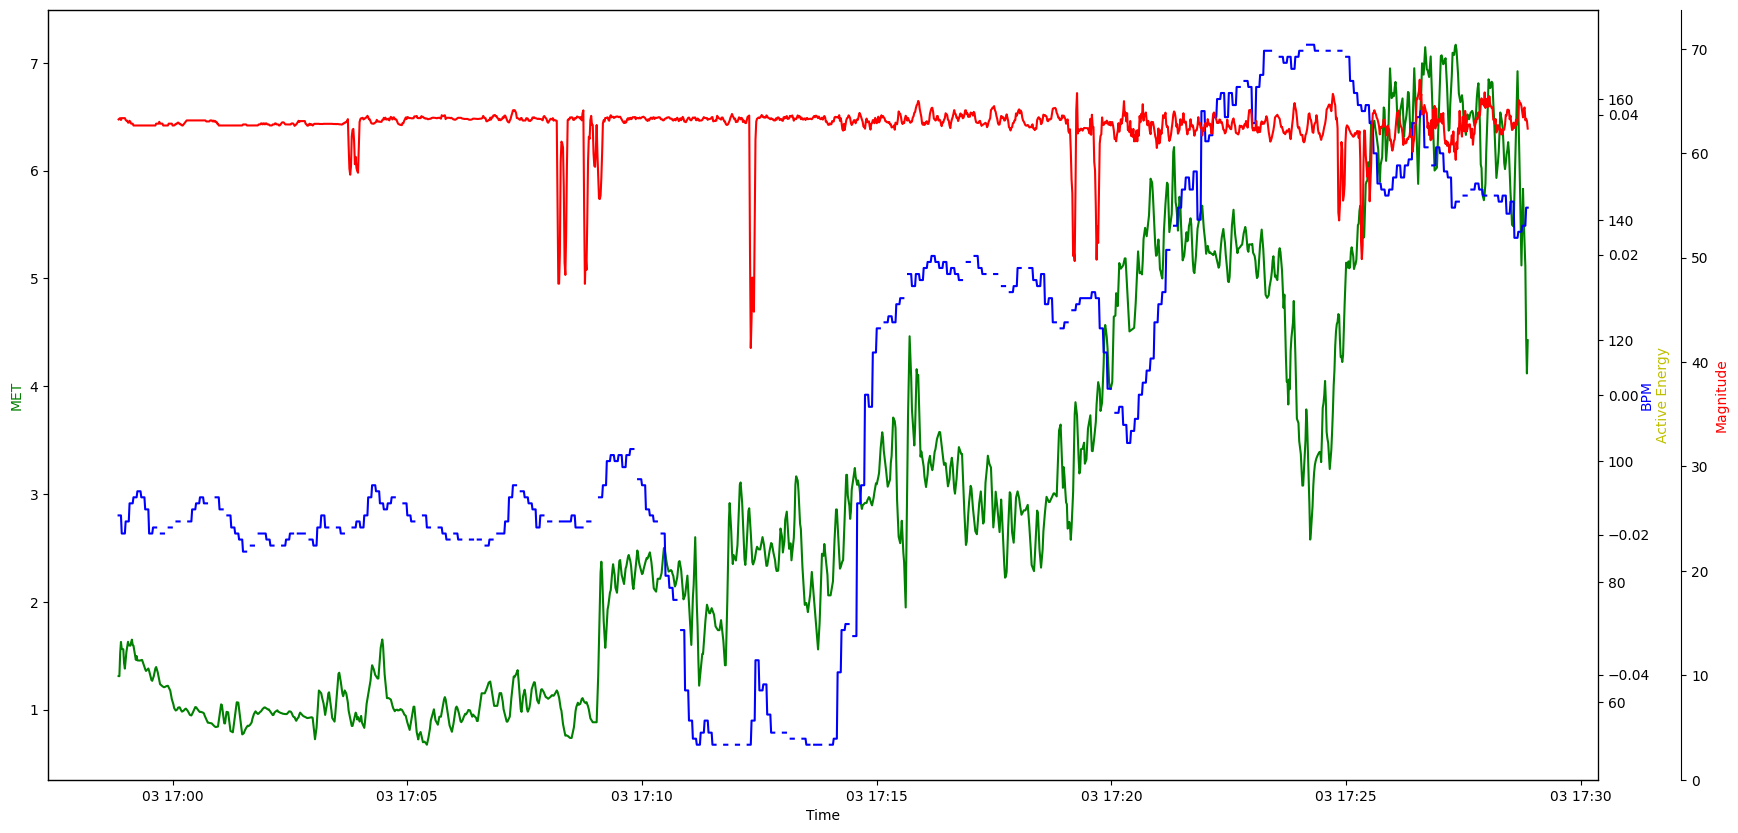

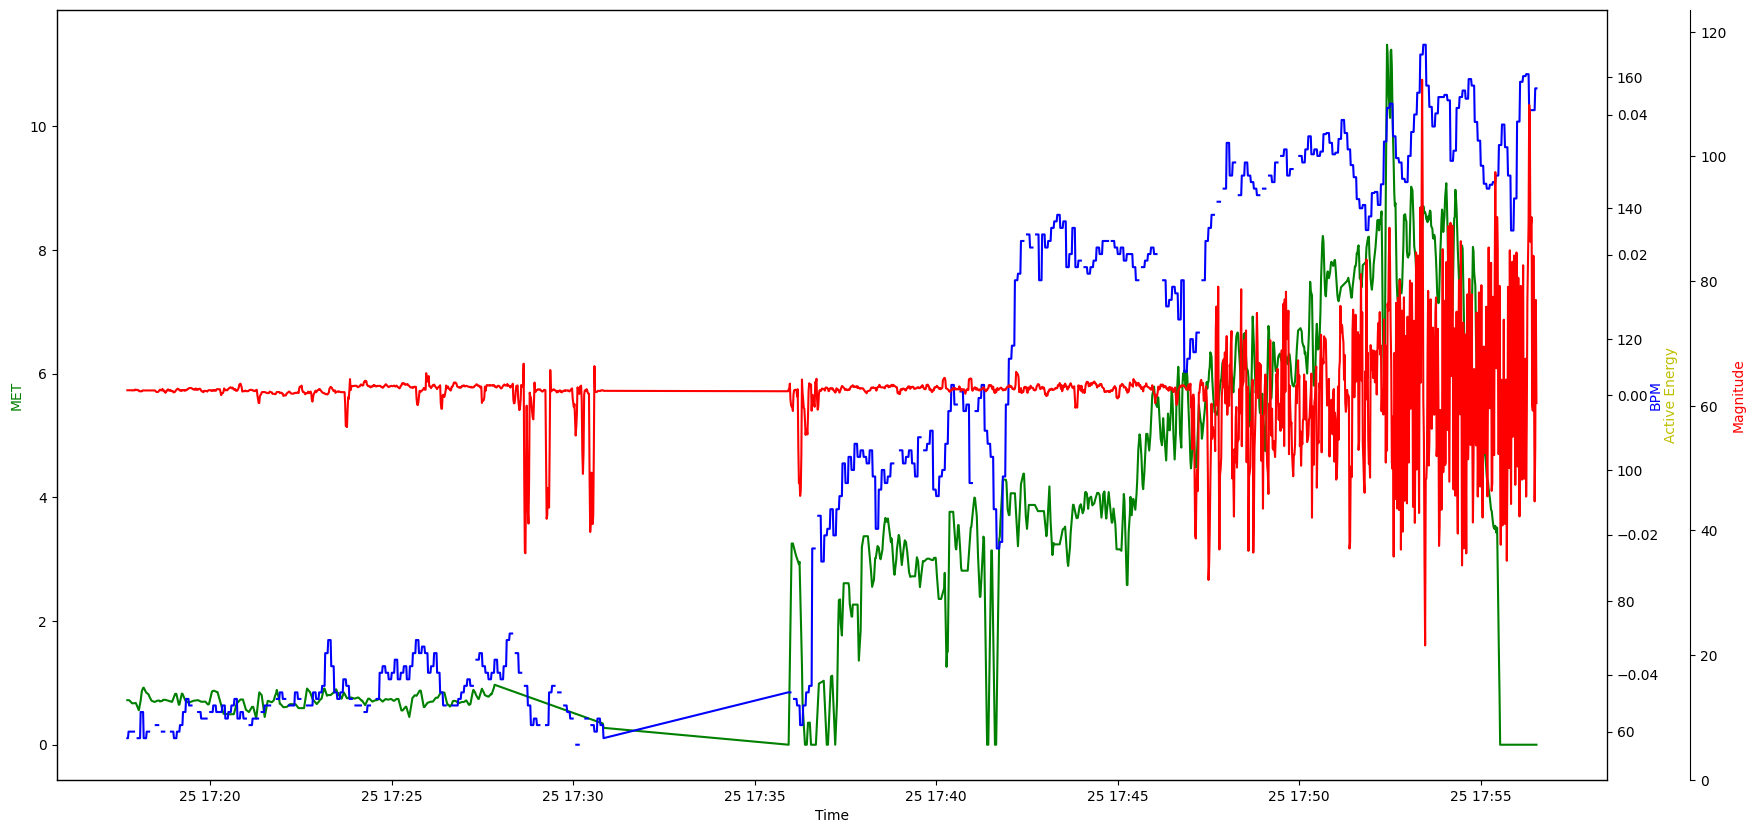

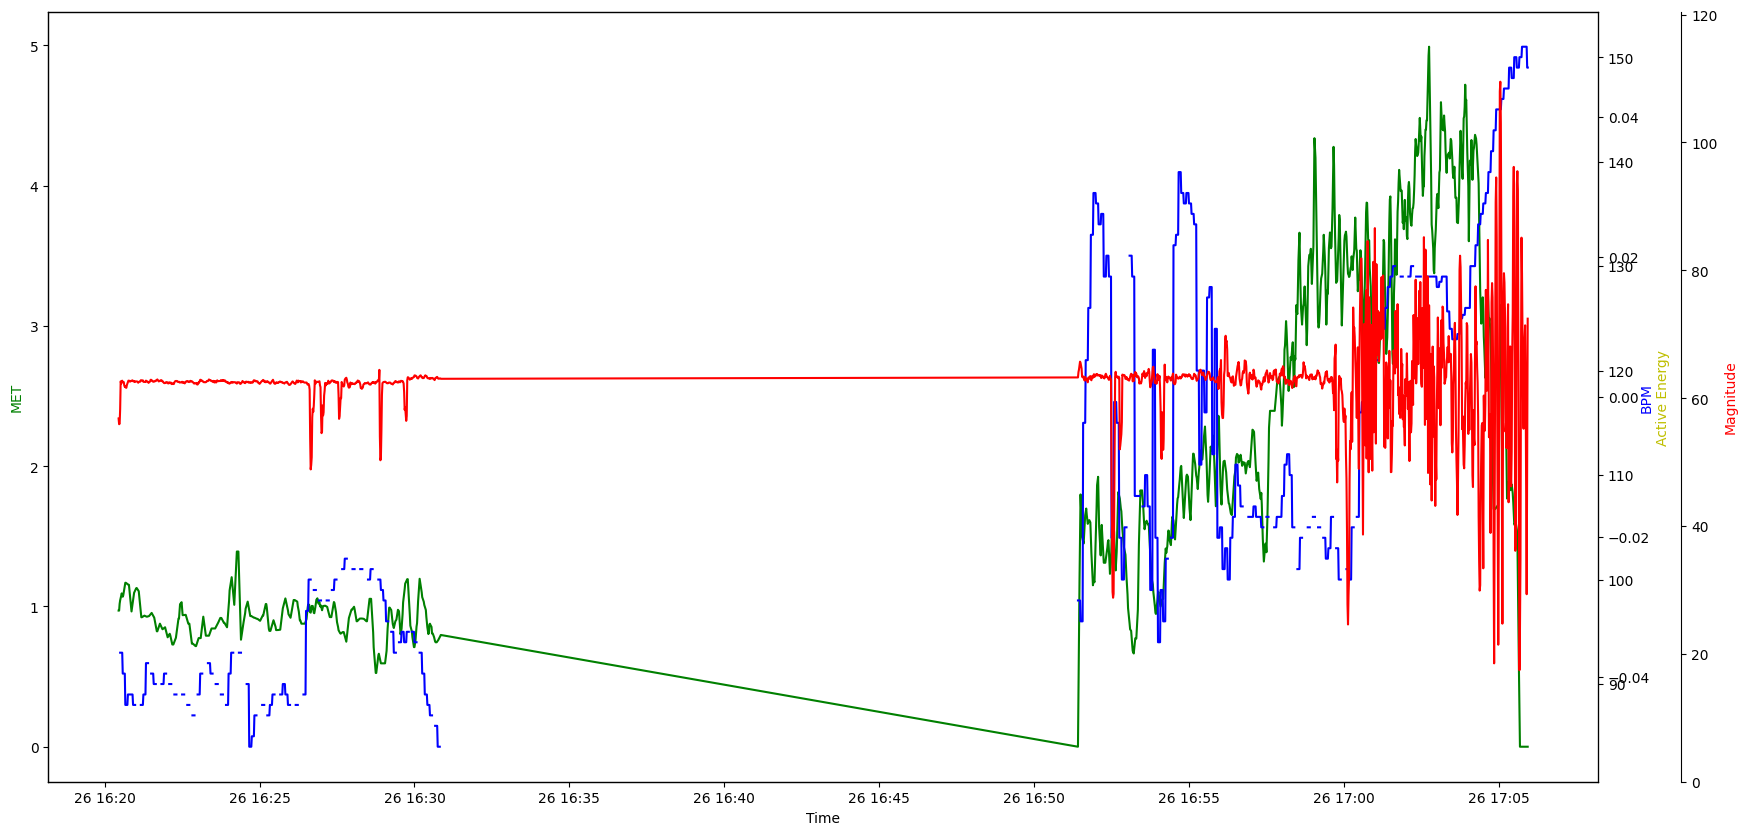

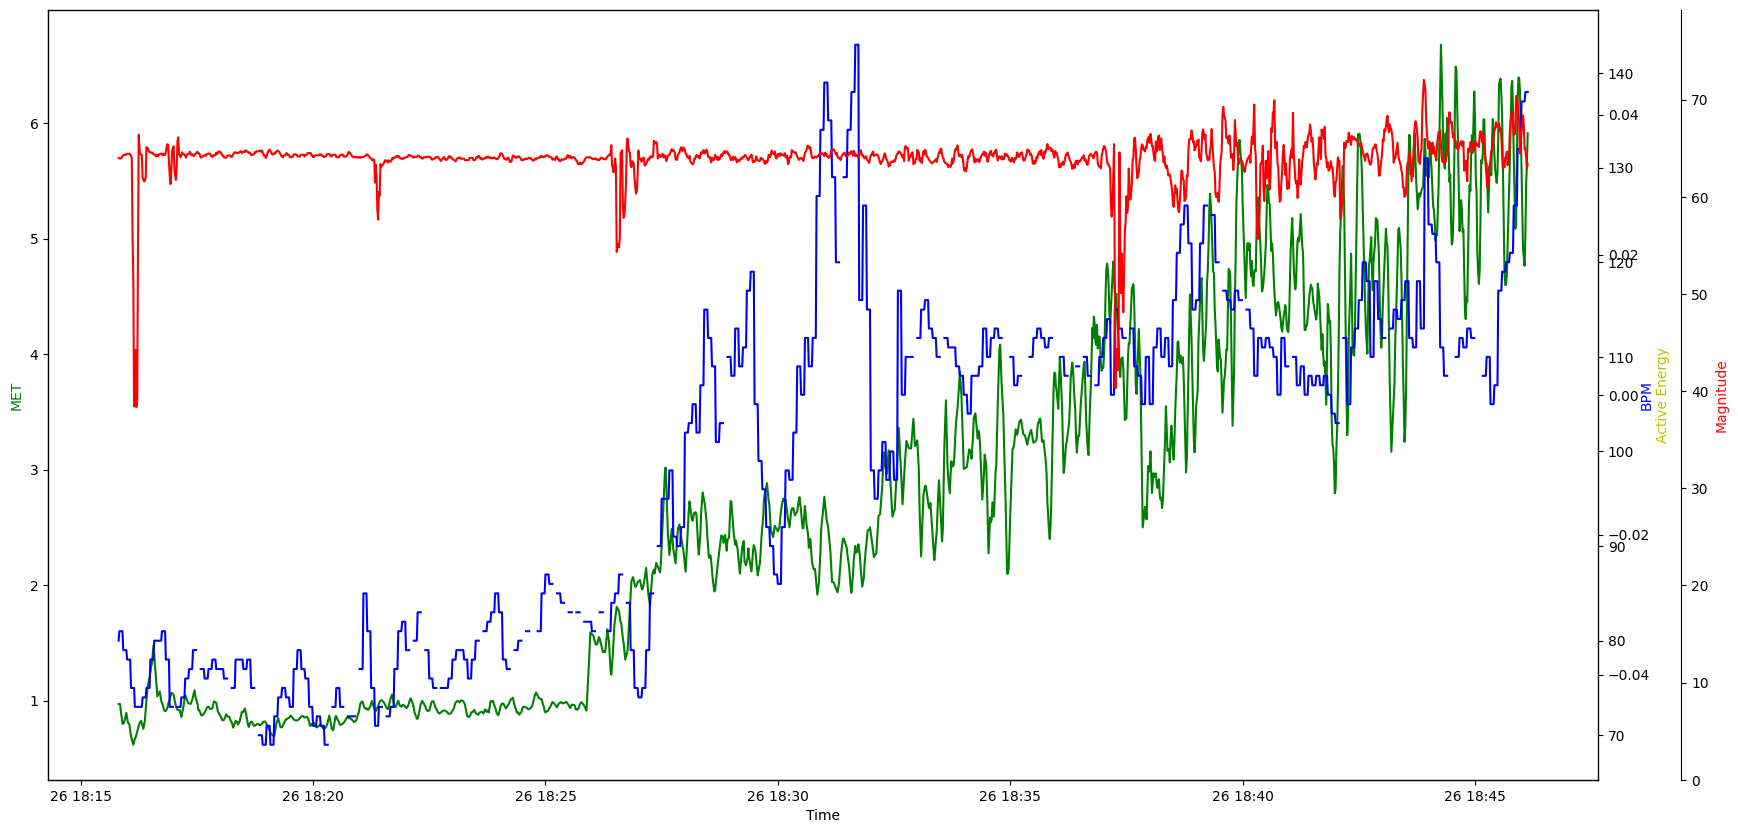

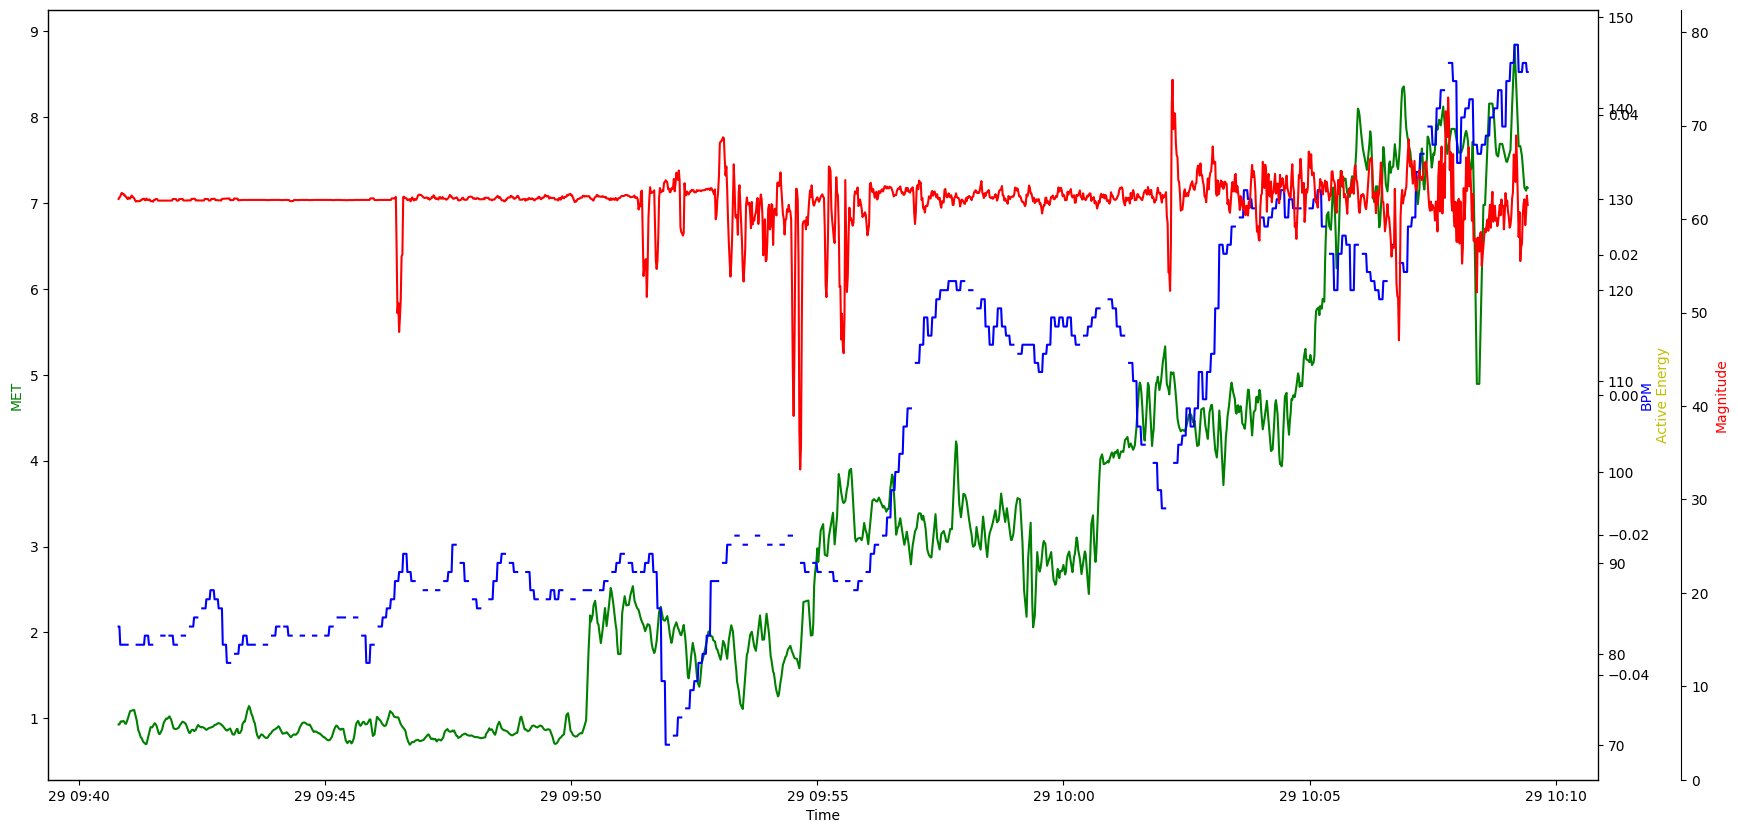

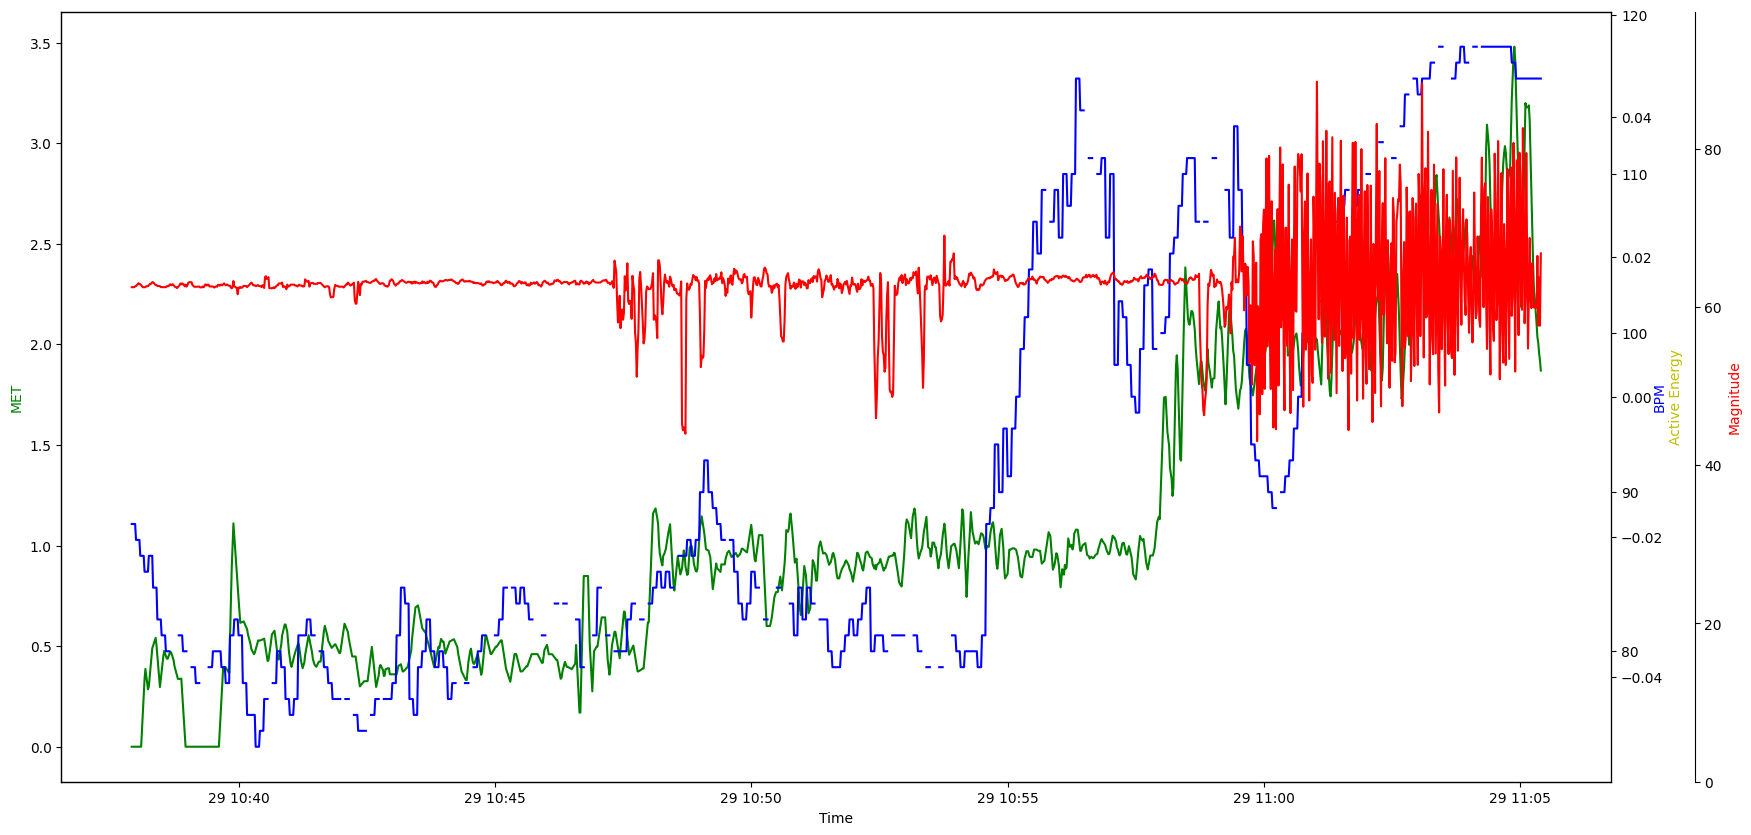

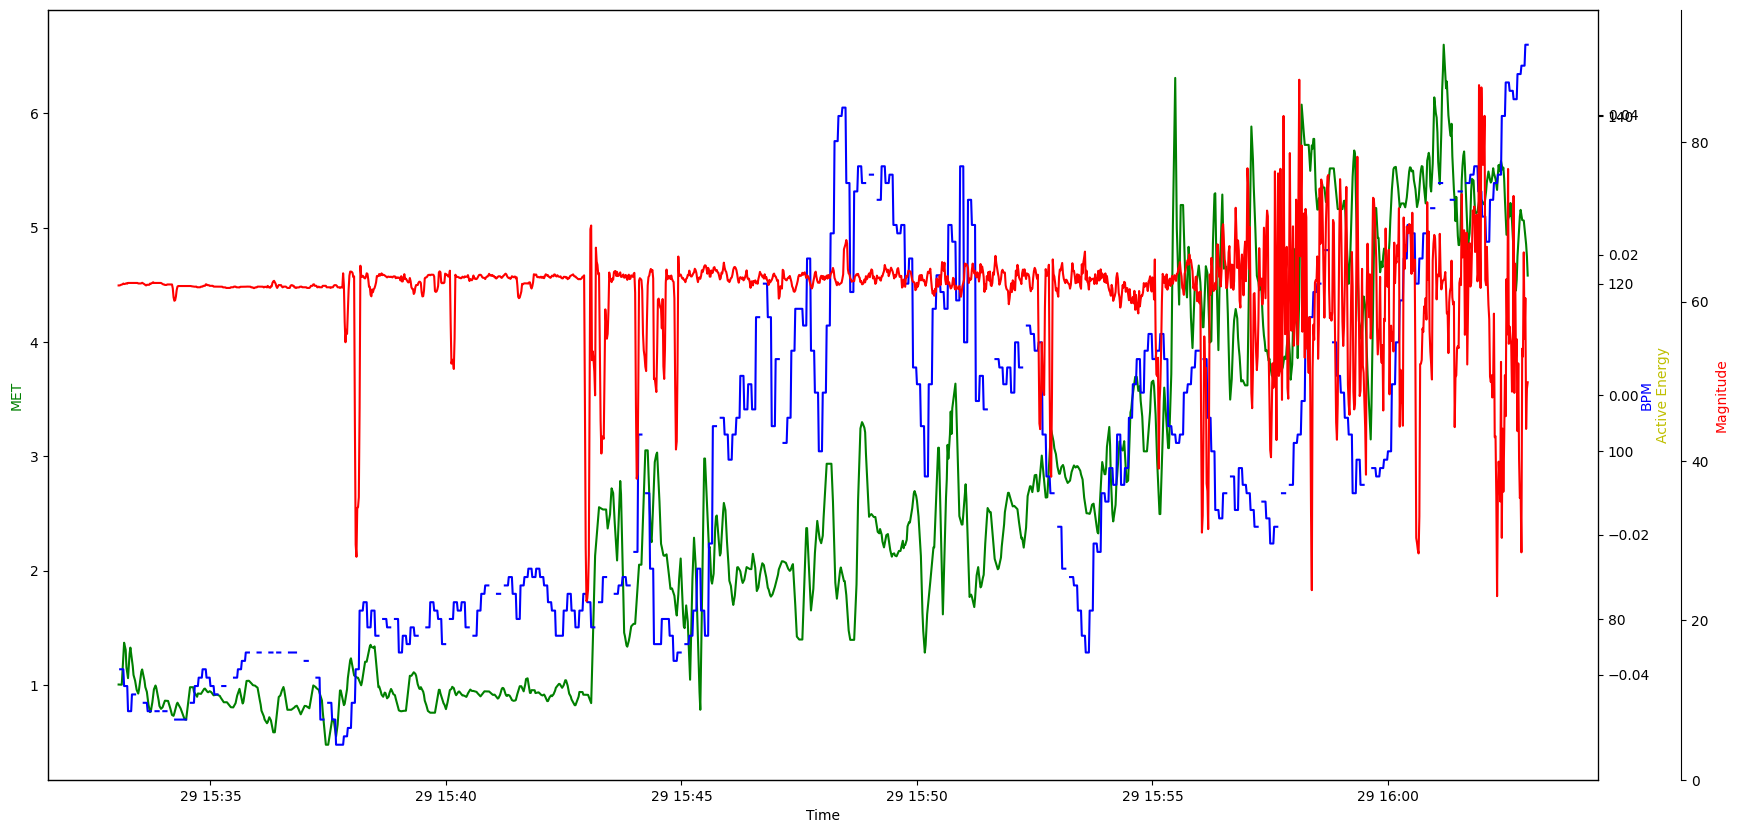

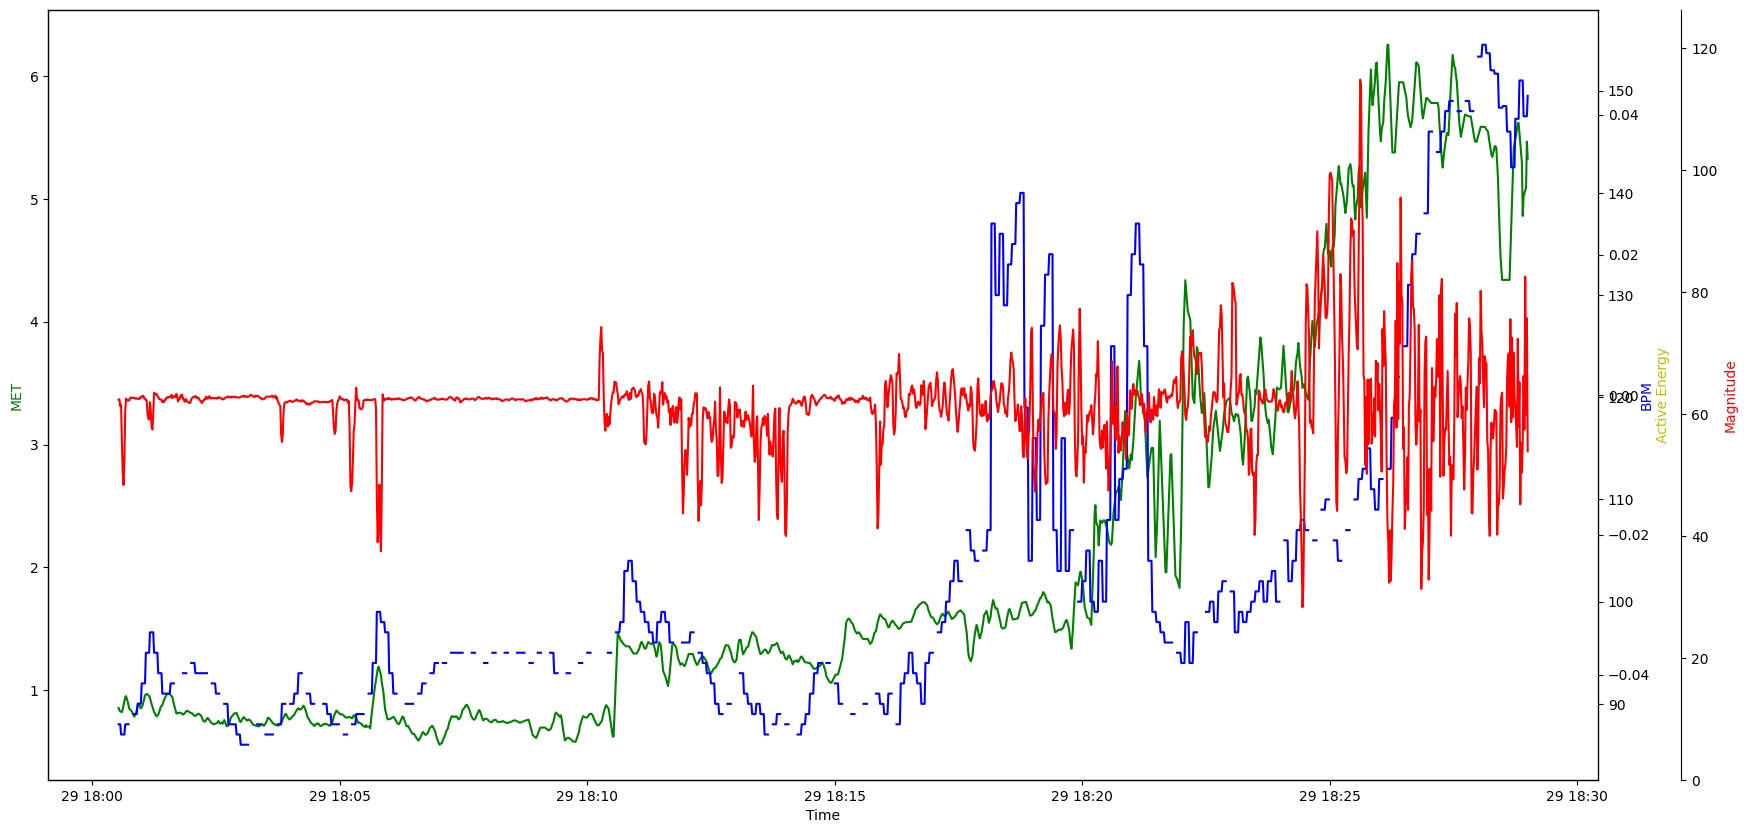

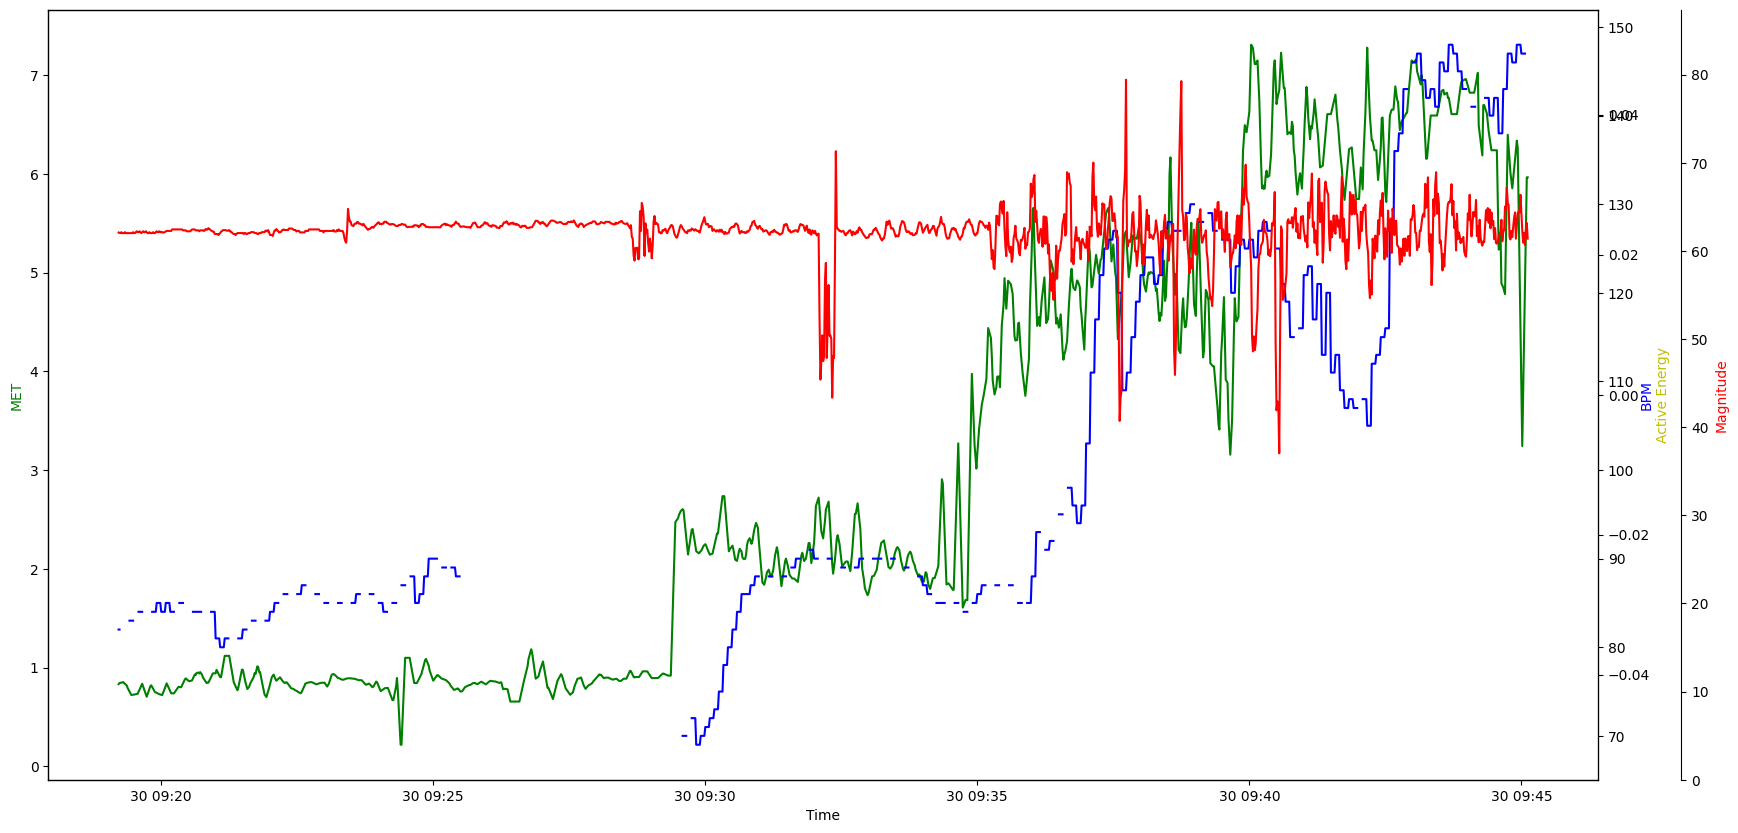

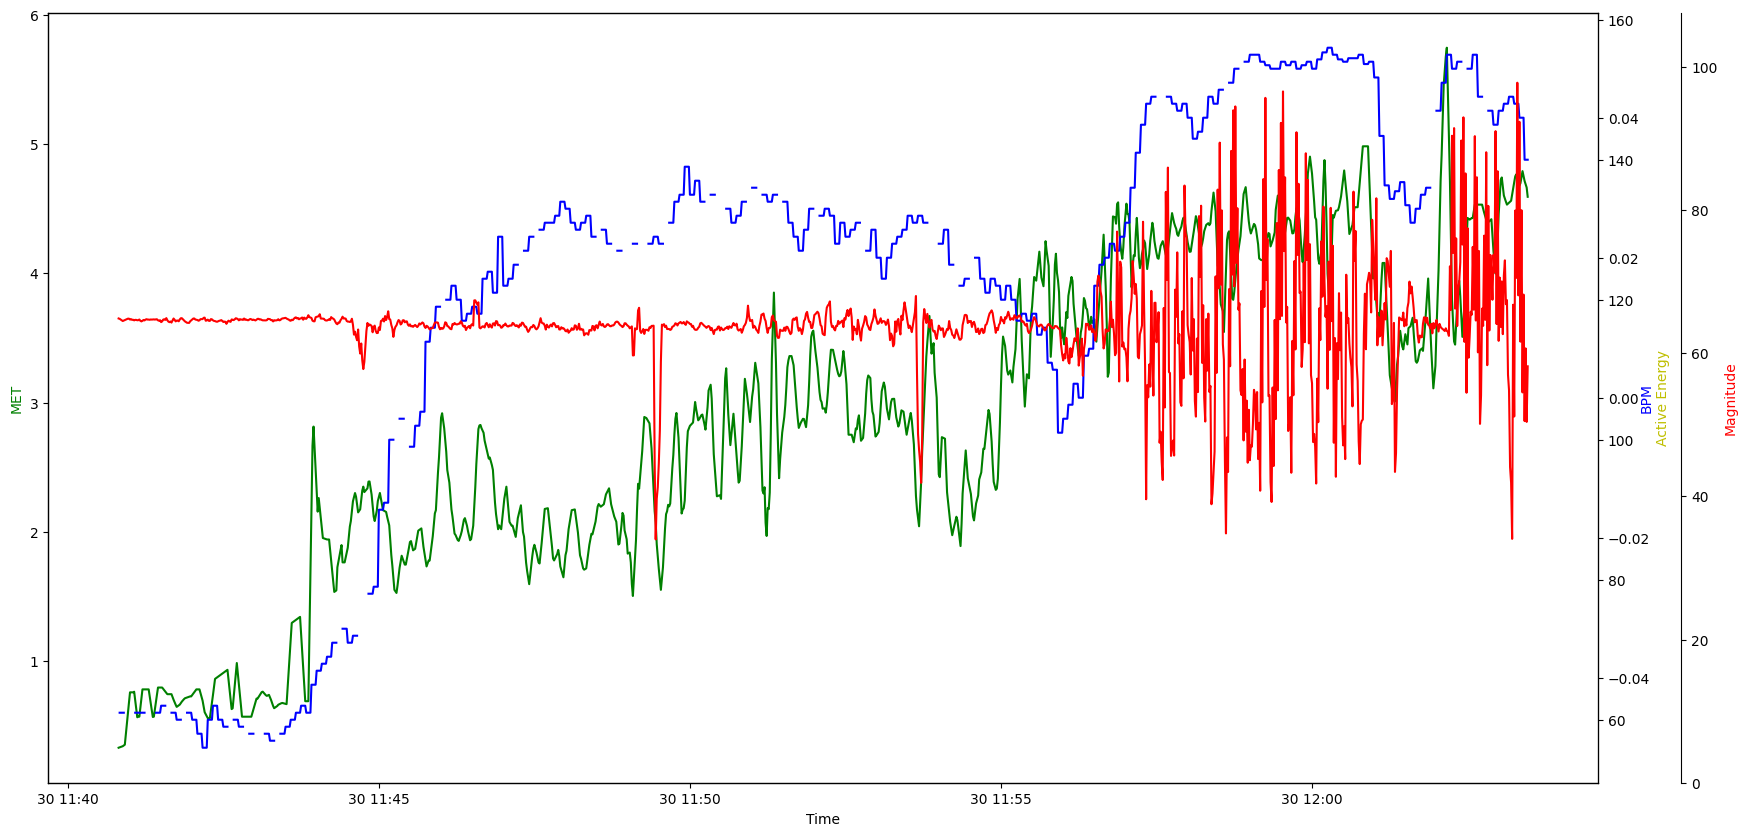

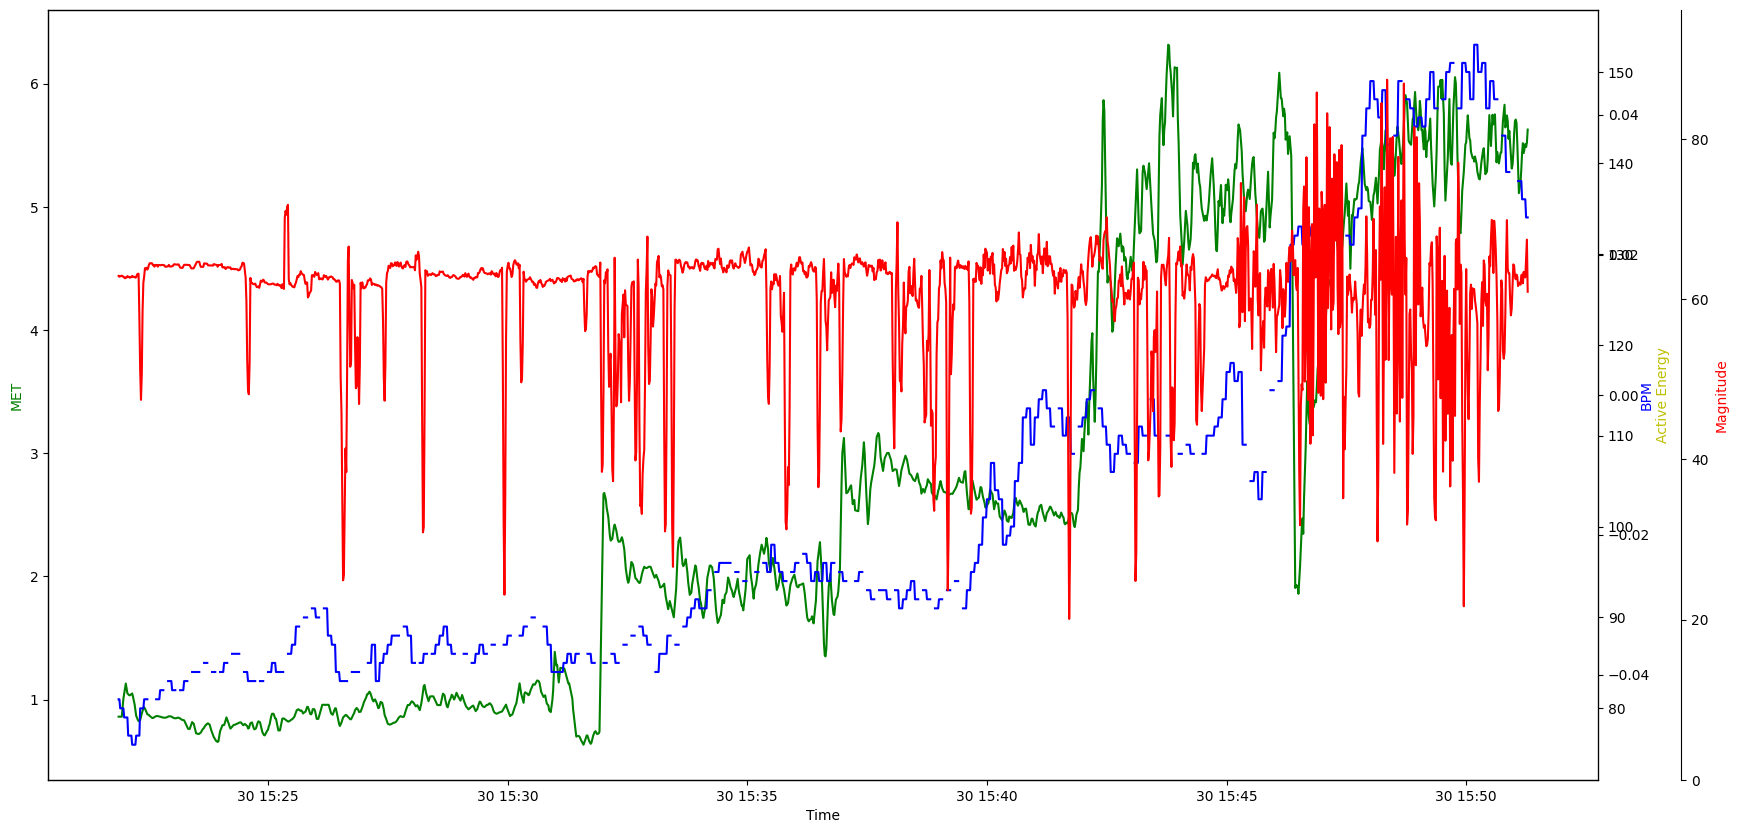

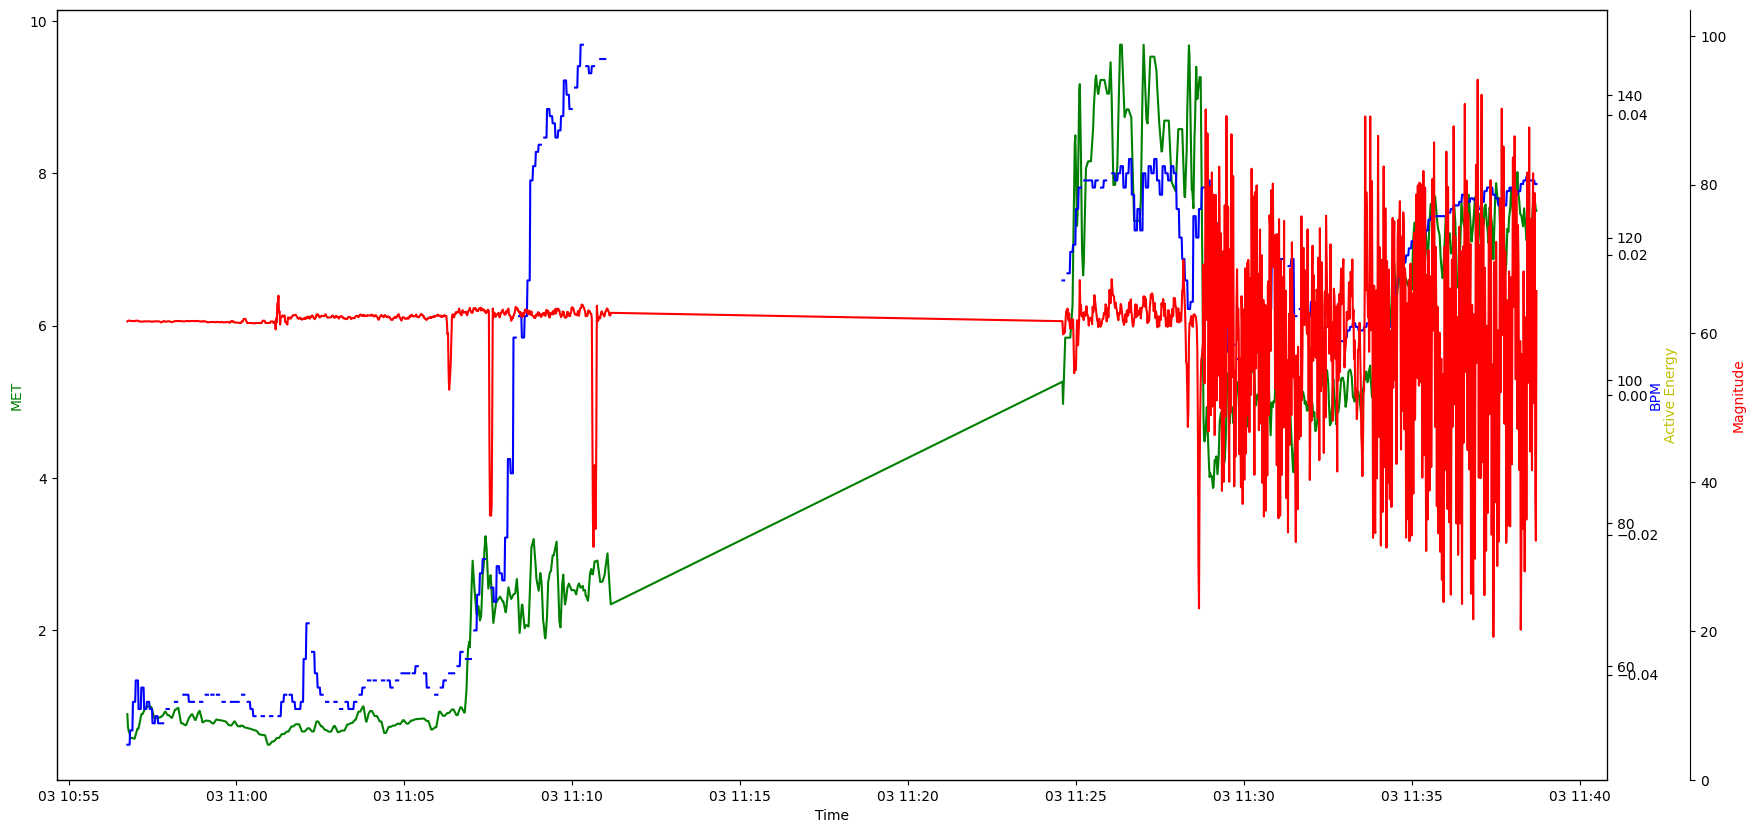

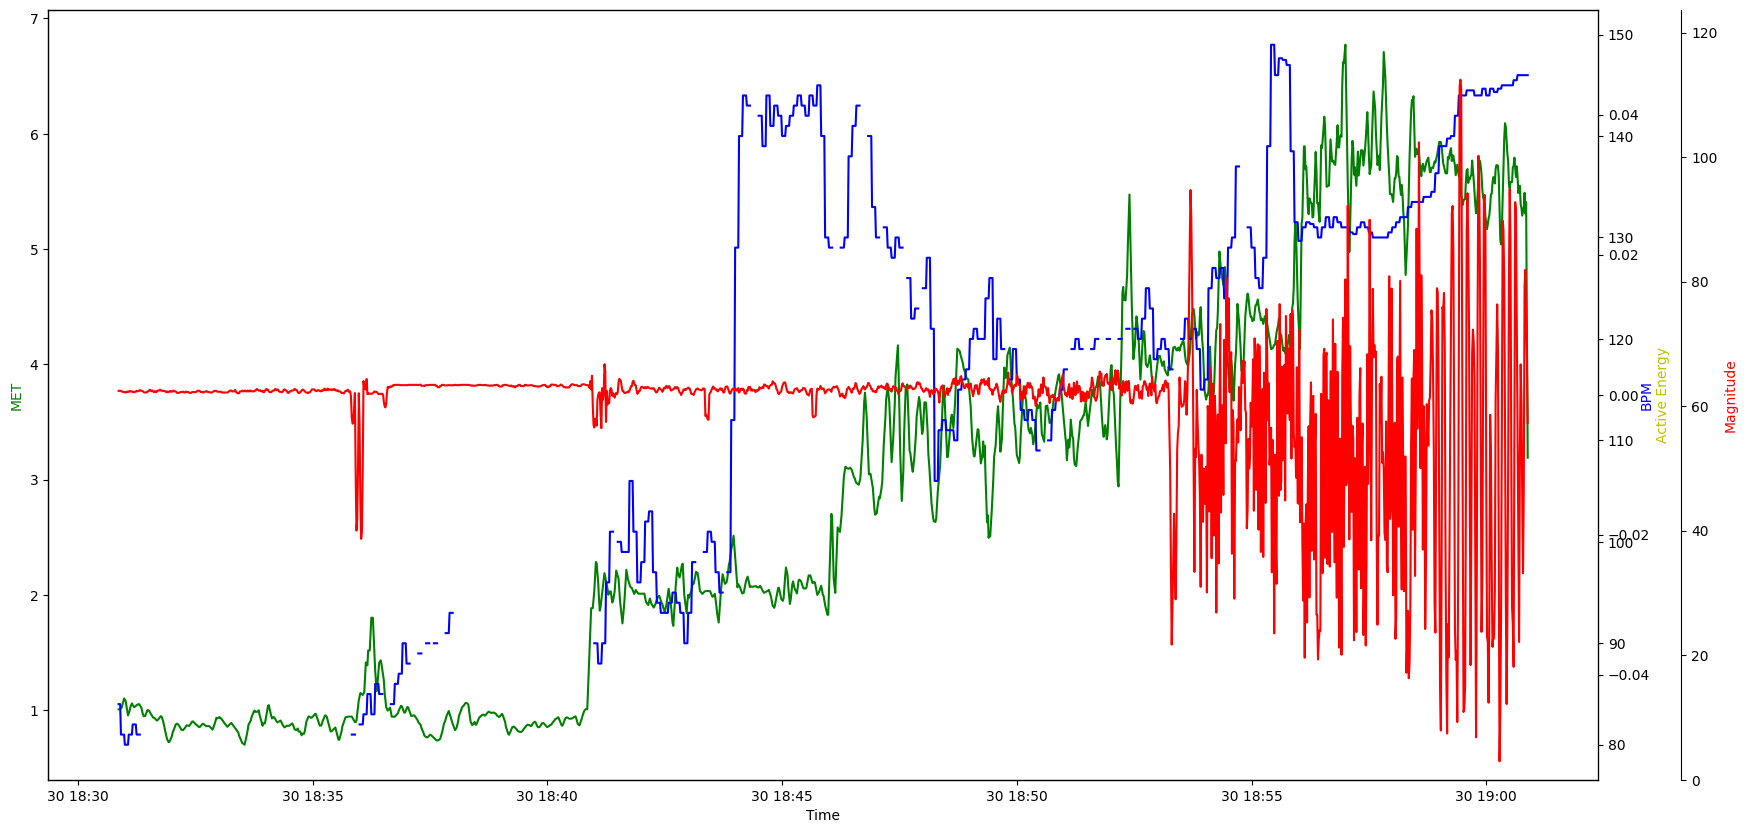

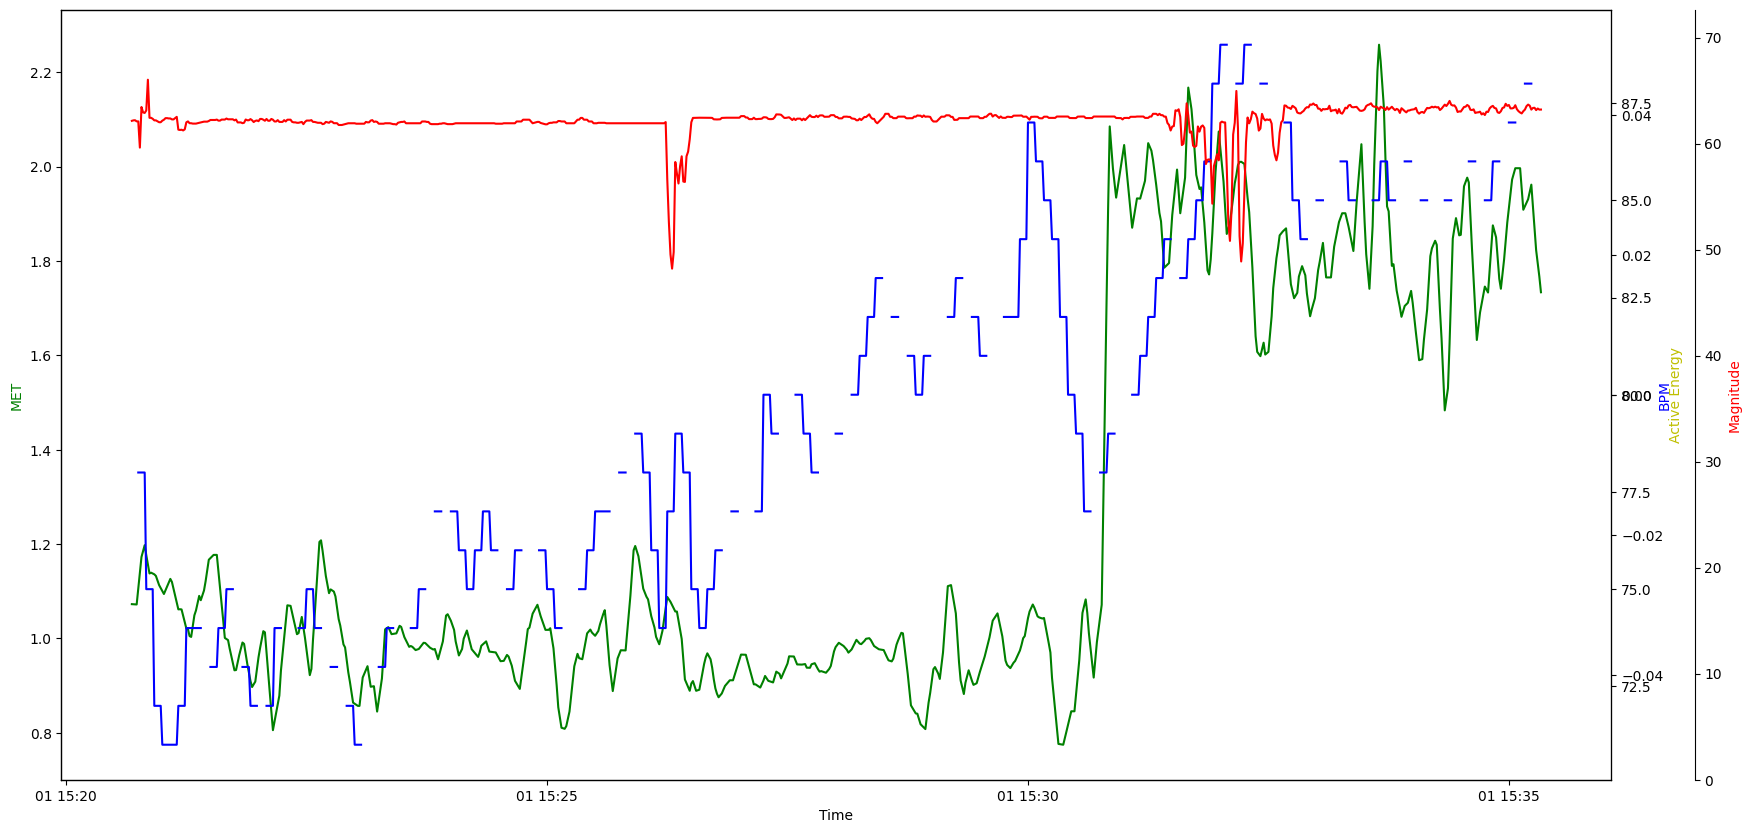

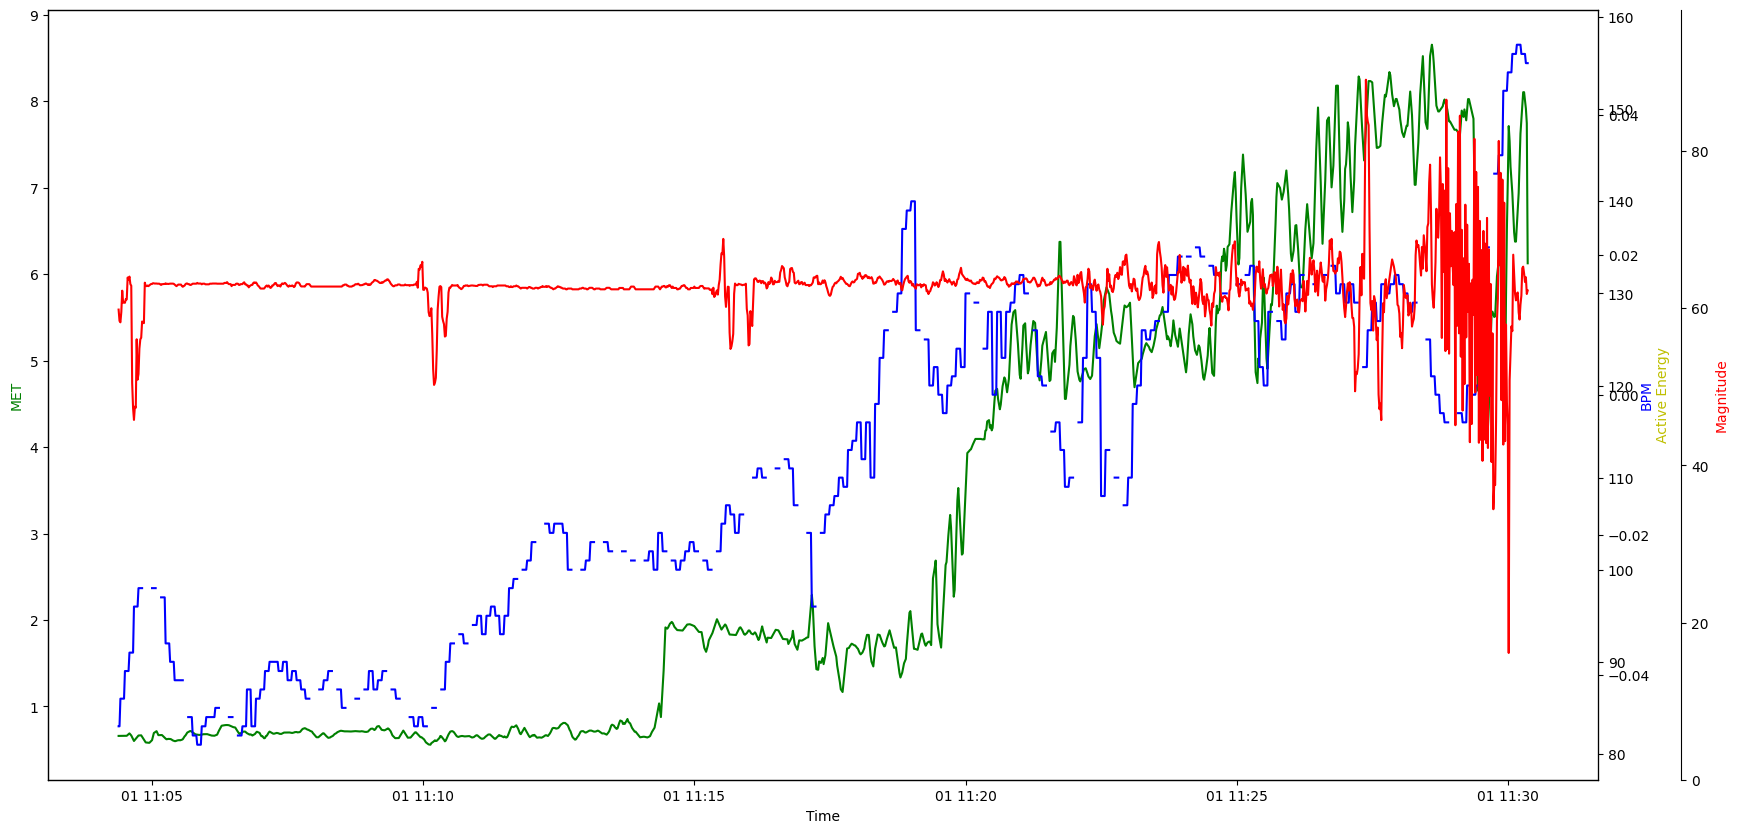

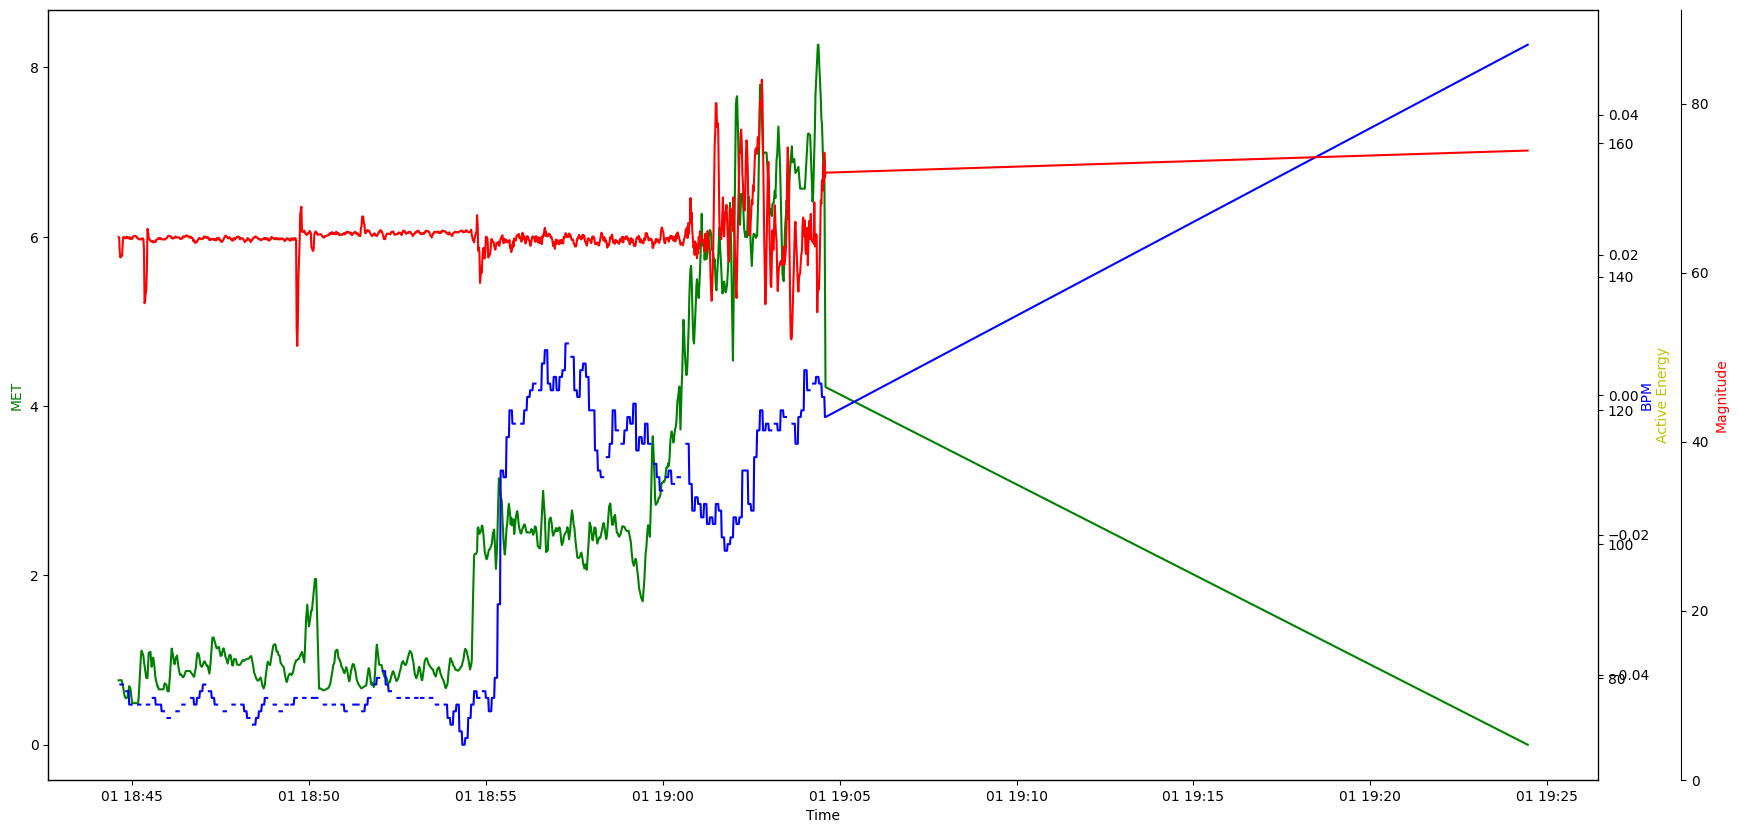

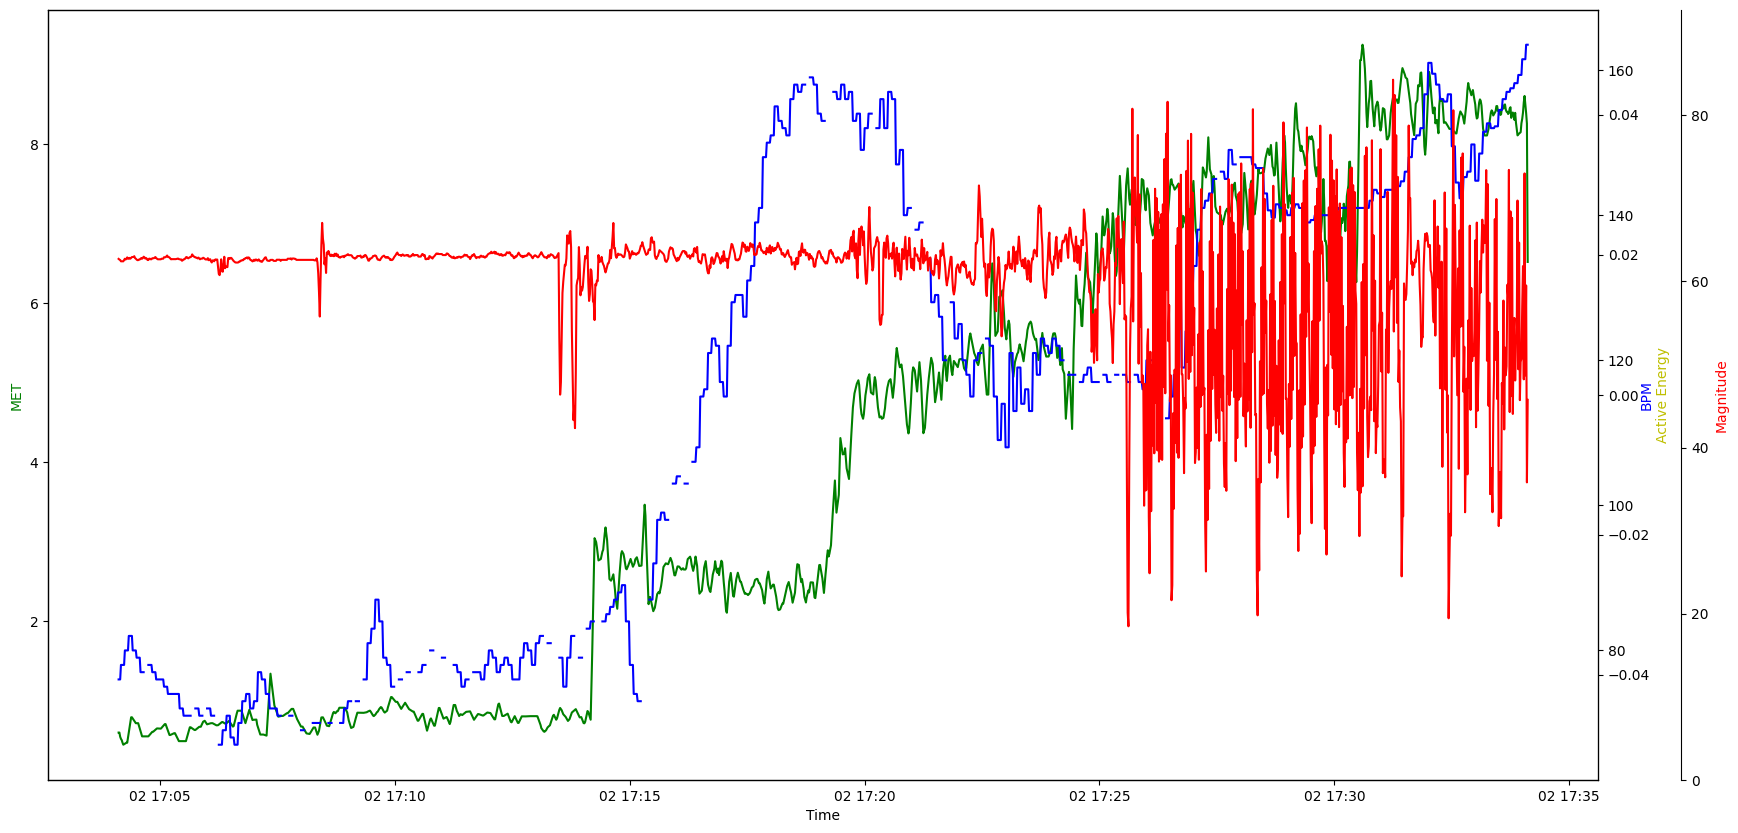

In [19]:
for df in merged_df_list:
    fig, ax1 = plt.subplots(figsize=(20, 10))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()

    # plot MET on the first y-axis
    ax1.plot(df.index, df["MET"], 'g-')
    ax1.set_ylabel('MET', color='g')

    # plot value_bpm on the second y-axis
    ax2.plot(df.index, df["value__bpm"], 'b-')
    ax2.set_ylabel('BPM', color='b')

    # plot Magnitude on the third y-axis
    ax3.plot(df.index, df["Magnitude"], 'r-')
    ax3.set_ylabel('Magnitude', color='r')

    #plot active energy (kJ) on the fourth y-axis
    ax4.plot(df.index, df["active energy (kJ)"], 'y-')
    ax4.set_ylabel('Active Energy', color='y')

    # adjust the position of the third y-axis
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylim(0, df["Magnitude"].max() * 1.1)
    ax3.set_ylabel('Magnitude', color='r')

    ax1.set_xlabel('Time')

    plt.show()